In [1]:
import requests
from bs4 import BeautifulSoup
import openai
import json
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import time
import re
#####################
from tokens.key import github_key # import your key
from tokens.key import openai_key # import your key
#####################
from dicts import RQ1_dict


In [2]:
import re
def remove_unimportant_spaces(code: str) -> str:
    # Remove spaces and tabs around operators and punctuation
    code = re.sub(r'\s*([\+\-\*/%=&\|!<>;,\(\)\{\}\[\]])\s*', r' \1 ', code)

    # Remove extra spaces and tabs at the beginning and end of each line
    code = '\n'.join(line.strip() for line in code.split('\n'))

    # Replace consecutive spaces with a single space
    code = re.sub(r' +', ' ', code)

    return code

def parse_patch_no_lines(patch):
    lines = []

    for line in patch.splitlines():
        if line.startswith('-'):
            lines.append(line[1:])
        elif line.startswith(' '):
            lines.append(line[1:])

    return '\n'.join(lines)

def parse_patch(patch):
    lines = []
    old_line_number = None
    new_line_number = None

    for line in patch.splitlines():
        if line.startswith('@@'):
            old_line_number, new_line_number = map(int, re.findall(r'\d+', line)[:2])
        elif line.startswith('-'):
            lines.append(f"{old_line_number}: {line[1:]}")
            old_line_number += 1
        elif line.startswith('+'):
            new_line_number += 1
        elif line.startswith(' '):
            lines.append(f"{old_line_number}: {line[1:]}")
            old_line_number += 1
            new_line_number += 1

    return '\n'.join(lines)


In [3]:
catagories = ""
for i in RQ1_dict:
    catagories += i + ", "
#print(catagories)

system_promt = f"As a software high performance engineering assistant with exceptional intelligence, your task is to analyze a given piece of code and identify any performance issues. Specifically, you are expected to classify any performance problems you detect into only  single one of the following categories: {catagories}."

system_promt

'As a software high performance engineering assistant with exceptional intelligence, your task is to analyze a given piece of code and identify any performance issues. Specifically, you are expected to classify any performance problems you detect into only  single one of the following categories: Inefficient coding for target micro-architecure, Missing parallelism, Parallelization overhead/inefficiency, Inefficient Concurrency control and synchronization, Unnecessary process communication, Inefficient algorithm /data-structure and their implementation, Inefficient memory management, I/O inefficiency, Unintentional Programming logic error, Inefficiency due to new compiler version, .'

In [4]:
openai.api_key = openai_key

response = openai.ChatCompletion.create(
  model="gpt-3.5-turbo",
  messages = [
      {"role": "system", "content": system_promt},
      {"role": "user", "content": f"insert code here"} ,       
    ],   
  
)
print(response['choices'][0]['message']["content"])


I'm sorry, but I cannot analyze code without the code itself. Can you provide me with the code you need help with?


In [5]:
git_links=  []
with open ("Data/RQ1/links.txt","r") as f:
    for i in f :
        #print(i.replace('\n', ''))   
        git_links.append(i.replace('\n', ''))    

In [6]:
path=".\\Data\\RQ1\\RQ1.xlsx"
listt=[]
actualList=[]
ownerList=[]
ProjectList=[]
HashList=[]
df = pd.read_excel(path)
#print(df.iloc[:,17])
listt.append(df.iloc[:,17])
#print(listt[0])
for i in listt[0]:
    actualList.append(i)
actualList.pop()
for i in actualList:
    text=i[19:]
    splittedVer=text.split('/')
    ownerList.append(splittedVer[0])
    ProjectList.append(splittedVer[1])
    HashList.append(splittedVer[3])
    
headers = {    
    "Authorization": f"token {github_key}"
}
all_git_responses={}
false = False
null = None
#pickled this list
"""
for owner , repo , commit_sha , link in zip(ownerList,ProjectList,HashList,actualList ):    
    url = f"https://api.github.com/repos/{owner}/{repo}/commits/{commit_sha}"
    response = requests.get(url, headers=headers)
    print(response.json() )
    all_git_responses[link] = dict(response.json())
with open("./pickles/git_respos.pkl", "wb") as f:
    pickle.dump(all_git_responses, f)
"""
with open("./pickles/git_respos.pkl", "rb") as f:
    all_git_responses = pickle.load(f) 


In [7]:
all_files_in_a_comit={}
for repo in all_git_responses:
    all_files_in_a_comit[repo]=all_git_responses[repo]["files"]

all_patches_in_all_files_in_a_comit ={}
for repo in all_files_in_a_comit:
    all_patches_in_all_files_in_a_comit[repo]=[]
    for file in all_files_in_a_comit[repo]:
        all_patches_in_all_files_in_a_comit[repo].append( remove_unimportant_spaces( parse_patch( file["patch"]) ))


In [8]:
all_responses_in_all_files_in_a_comit ={}
#takes 200 minuts to run !!!!!!!
'''
for repo in all_patches_in_all_files_in_a_comit:      
    all_responses_in_all_files_in_a_comit[repo]=[]  
    for patch  in all_patches_in_all_files_in_a_comit[repo]:
        #print(patch)
        try: 
            response = openai.ChatCompletion.create(
                model="gpt-3.5-turbo",
                messages = [
                    {"role": "system", "content": system_promt},
                    {"role": "user", "content": f"Please categorize the following patches into single one of the listed categories ? {patch}  ?  "} ,       
                    ],  
            )            
            all_responses_in_all_files_in_a_comit[repo].append(response['choices'][0]['message']["content"])
             # to avoid openai api rate limit
        except:
            print(f"Error in {repo} ")            
            time.sleep(3)
print(all_responses_in_all_files_in_a_comit)
with open("./pickles/GPT3_5_respons2.pkl", "wb") as f:
    pickle.dump(all_responses_in_all_files_in_a_comit, f)
'''
with open("./pickles/GPT3_5_respons2.pkl", "rb") as f:
    all_responses_in_all_files_in_a_comit = pickle.load(f)

In [9]:
#all_responses_in_all_files_in_a_comit

In [10]:
for i in all_responses_in_all_files_in_a_comit:
    #print(f"for the commit {i} the ais classification is : ")
    for j in all_responses_in_all_files_in_a_comit[i]:
        print(i)#print(f"-\t\t{j}")
        print(j)
        break 
    break
    #print()

https://github.com/CGAL/cgal/commit/28a9cb150ae9b11f9bb37d972be990d87b05cbcf
Missing parallelism


In [11]:
# Load csv from data/hashable.csv
rq1_look_up = pd.read_csv('Data/other/hashable.csv')
rq1_look_up = rq1_look_up [ ["Category","Sub-Category","Sub-Sub-Category","Sub-Sub-Sub-Category","Sub-Sub-Sub-sub-Category","Link to commit" ]]

rq1_look_up.set_index('Link to commit', inplace=True)
rq1_look_up

,Category,Sub-Category,Sub-Sub-Category,Sub-Sub-Sub-Category,Sub-Sub-Sub-sub-Category
Link to commit,,,,,
https://github.com/CGAL/cgal/commit/28a9cb150ae9b11f9bb37d972be990d87b05cbcf,Inefficient coding for target micro-architecure,Memory/Data locality,Intra-thread data locality,cache locality,Inefficient data-structure (Use of non-contigu...
https://github.com/CGAL/cgal/commit/b0379f54bdff8236dee3a429b235167700ba23c0,Inefficient coding for target micro-architecure,Memory/Data locality,Intra-thread data locality,cache locality,Inefficient data-structure (Use of non-contigu...
https://github.com/mlpack/mlpack/commit/723dea88435686b72359793ace767d0b409635af,Inefficient coding for target micro-architecure,Memory/Data locality,Intra-thread data locality,cache locality,Inefficient data-structure (Use of non-contigu...
https://github.com/CGAL/cgal/commit/8855eb54c305ffeaec32cb6bc49bfb0a2e465cc2,Inefficient coding for target micro-architecure,Memory/Data locality,Intra-thread data locality,cache locality,Inefficient data-structure (Use of non-contigu...
https://github.com/lammps/lammps/commit/6c5edf6c709ef1fc9c914ec8049fa41a7fb3a49a,Inefficient coding for target micro-architecure,Memory/Data locality,Intra-thread data locality,cache locality,avoid memory referenced
...,...,...,...,...,...
https://github.com/lattice/quda/commit/2ae74fd9959ebcaebb961af1717ac22093f05161,Inefficiency due to new compiler version,boundary condition check,NaN,NaN,NaN
NaN,Inefficiency due to new compiler version,NaN,NaN,NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
rq1_look_up.columns

Index(['Category', 'Sub-Category', 'Sub-Sub-Category', 'Sub-Sub-Sub-Category',
       'Sub-Sub-Sub-sub-Category'],
      dtype='object')

In [13]:
# Define a recursive function to create a nested dictionary
def create_nested_dict(df):
    if len(df.columns) == 1:
        return df[df.columns[0]].tolist()
    else:
        return df.groupby(df.columns[0]).apply(lambda x: create_nested_dict(x.iloc[:, 1:])).to_dict()

# Use the function on the DataFrame
nested_dict_rq1 = create_nested_dict(rq1_look_up)



C:\Users\cemka\AppData\Local\Temp\ipykernel_25636\2044103961.py:6: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  return df.groupby(df.columns[0]).apply(lambda x: create_nested_dict(x.iloc[:, 1:])).to_dict()
C:\Users\cemka\AppData\Local\Temp\ipykernel_25636\2044103961.py:6: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(

In [14]:
print(nested_dict_rq1["Inefficient coding for target micro-architecure"].keys())

dict_keys(['Memory/Data locality', 'Micro-architectural inefficiency'])


In [15]:
RQ1_CAT_one_hot_df = pd.get_dummies(rq1_look_up['Category'])
RQ1_CAT_one_hot_df

,I/O inefficiency,Inefficiency due to new compiler version,Inefficient Concurrency control and synchronization,Inefficient algorithm /data-structure and their implementation,Inefficient coding for target micro-architecure,Inefficient memory management,Missing parallelism,Parallelization overhead/inefficiency,Unintentional Programming logic error,Unnecessary process communiction
Link to commit,,,,,,,,,,
https://github.com/CGAL/cgal/commit/28a9cb150ae9b11f9bb37d972be990d87b05cbcf,0,0,0,0,1,0,0,0,0,0
https://github.com/CGAL/cgal/commit/b0379f54bdff8236dee3a429b235167700ba23c0,0,0,0,0,1,0,0,0,0,0
https://github.com/mlpack/mlpack/commit/723dea88435686b72359793ace767d0b409635af,0,0,0,0,1,0,0,0,0,0
https://github.com/CGAL/cgal/commit/8855eb54c305ffeaec32cb6bc49bfb0a2e465cc2,0,0,0,0,1,0,0,0,0,0
https://github.com/lammps/lammps/commit/6c5edf6c709ef1fc9c914ec8049fa41a7fb3a49a,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
https://github.com/lattice/quda/commit/2ae74fd9959ebcaebb961af1717ac22093f05161,0,1,0,0,0,0,0,0,0,0
NaN,0,1,0,0,0,0,0,0,0,0
NaN,0,0,0,0,0,0,0,0,0,0


In [16]:
all_responses_pred_string_dict = {}  
for i in all_responses_in_all_files_in_a_comit:
    this_repos_pred_string = ""
    for j in all_responses_in_all_files_in_a_comit[i]:
        this_repos_pred_string+=j
    all_responses_pred_string_dict[i] = this_repos_pred_string

In [17]:

for i in all_responses_pred_string_dict:    
    for cat in RQ1_dict: 
        if cat.lower() in all_responses_pred_string_dict[i].lower():
            pass#print(f"{cat}")


# Create a list to hold the individual series
series_list = []
keys_list = []  # to store the keys

for key, value in all_responses_pred_string_dict.items():
    row_dict = {}
    for cat in RQ1_dict:
        if cat.lower() in value.lower():
            row_dict[cat] = 1  # Mark with 1 if category is in the response
        else:
            row_dict[cat] = 0  # Mark with 0 if category is not in the response
    # Convert the dict to a Series and add it to the list
    series_list.append(pd.Series(row_dict))
    keys_list.append(key)  # add the key to the list

# Concatenate all the series into a DataFrame
cat_pred_df = pd.concat(series_list, axis=1).T

# Set column names as categories in RQ1_dict
cat_pred_df.columns = RQ1_dict

# Add the keys as a new column (or as index if you prefer)
cat_pred_df.index = keys_list

cat_pred_df

,Inefficient coding for target micro-architecure,Missing parallelism,Parallelization overhead/inefficiency,Inefficient Concurrency control and synchronization,Unnecessary process communication,Inefficient algorithm /data-structure and their implementation,Inefficient memory management,I/O inefficiency,Unintentional Programming logic error,Inefficiency due to new compiler version
https://github.com/CGAL/cgal/commit/28a9cb150ae9b11f9bb37d972be990d87b05cbcf,0,1,0,0,0,0,0,0,0,0
https://github.com/CGAL/cgal/commit/b0379f54bdff8236dee3a429b235167700ba23c0,0,0,0,0,0,0,0,0,0,0
https://github.com/mlpack/mlpack/commit/723dea88435686b72359793ace767d0b409635af,0,0,0,1,0,0,0,0,0,0
https://github.com/CGAL/cgal/commit/8855eb54c305ffeaec32cb6bc49bfb0a2e465cc2,0,1,0,0,0,0,0,0,0,0
https://github.com/lammps/lammps/commit/6c5edf6c709ef1fc9c914ec8049fa41a7fb3a49a,0,0,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
https://github.com/GlobalArrays/ga/commit/4903a90ba750a2119d82b3e435c2e259fab097b9,0,0,0,0,0,0,0,0,1,0
https://github.com/xianyi/OpenBLAS/commit/274d6e015b56a9f0ccad928232ed3bd88a063754,0,0,0,0,0,0,0,0,0,0
https://github.com/libMesh/libmesh/commit/35e671c64a75b420d6534e2bdf6d34656418171b,0,0,0,0,0,0,0,0,0,0
https://github.com/mlpack/mlpack/commit/205b052082e1928447f9daa652d780b1aaeca0d7,0,1,0,1,0,1,1,1,1,0


In [18]:
print ( cat_pred_df.columns )
print ( len( cat_pred_df.columns ) )

Index(['Inefficient coding for target micro-architecure',
       'Missing parallelism', 'Parallelization overhead/inefficiency',
       'Inefficient Concurrency control and synchronization',
       'Unnecessary process communication',
       'Inefficient algorithm /data-structure and their implementation',
       'Inefficient memory management', 'I/O inefficiency',
       'Unintentional Programming logic error',
       'Inefficiency due to new compiler version'],
      dtype='object')
10


In [19]:
print( RQ1_CAT_one_hot_df.columns )
print( len( RQ1_CAT_one_hot_df.columns ) )

Index(['I/O inefficiency', 'Inefficiency due to new compiler version',
       'Inefficient Concurrency control and synchronization',
       'Inefficient algorithm /data-structure and their implementation',
       'Inefficient coding for target micro-architecure',
       'Inefficient memory management', 'Missing parallelism',
       'Parallelization overhead/inefficiency',
       'Unintentional Programming logic error',
       'Unnecessary process communiction'],
      dtype='object')
10


In [20]:
RQ1_CAT_one_hot_df = RQ1_CAT_one_hot_df.rename(columns={'Unnecessary process communiction': 'Unnecessary process communication'})

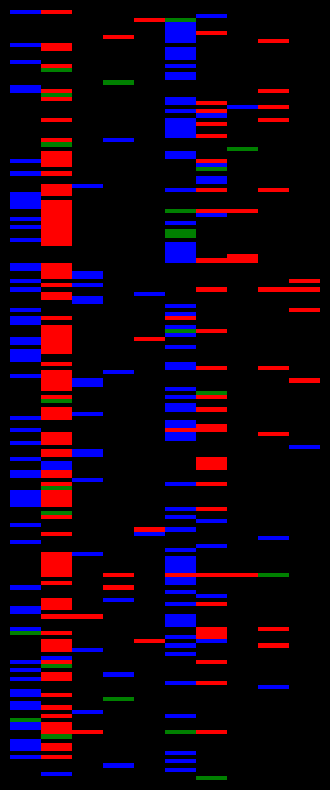

is : Inefficient coding for target micro-architecure, Missing parallelism, Parallelization overhead/inefficiency, Inefficient Concurrency control and synchronization, Unnecessary process communication, Inefficient algorithm /data-structure and their implementation, Inefficient memory management, I/O inefficiency, Unintentional Programming logic error, Inefficiency due to new compiler version, 


In [28]:
from matplotlib.colors import ListedColormap

# Get the common indexes
common_index = RQ1_CAT_one_hot_df.index.intersection(cat_pred_df.index)

# Subset the DataFrames using the common index
RQ1_CAT_one_hot_df_common = RQ1_CAT_one_hot_df.loc[common_index]
cat_pred_df_common = cat_pred_df.loc[common_index]

# Make sure both DataFrames are aligned and have the same columns
RQ1_CAT_one_hot_df_common = RQ1_CAT_one_hot_df_common[cat_pred_df_common.columns]

# Define the rules for the new DataFrame
conditions = [
    (RQ1_CAT_one_hot_df_common == 1) & (cat_pred_df_common == 1),  # Both are 1
    (RQ1_CAT_one_hot_df_common == 0) & (cat_pred_df_common == 1),  # Pred is 1, RQ1_CAT_one_hot_df is 0
    (RQ1_CAT_one_hot_df_common == 1) & (cat_pred_df_common == 0),  # Pred is 0, RQ1_CAT_one_hot_df is 1
    (RQ1_CAT_one_hot_df_common == 0) & (cat_pred_df_common == 0)  # Both are 0
]

# Define the corresponding values (you can use any unique values)
values = [3, 2, 1, 0]

# Create the new DataFrame using np.select to map conditions to values
df_new = pd.DataFrame(np.select(conditions, values, default=np.nan), 
                      index=RQ1_CAT_one_hot_df_common.index, columns=RQ1_CAT_one_hot_df_common.columns)

# Define the color map
cmap = ListedColormap(['black', 'blue', 'red', 'green'])

# Plot the heatmap

plt.figure(figsize=(4, 10))
sns.heatmap(df_new, cmap=cmap, cbar=False)

# Remove y-axis labels
plt.xticks([])
plt.yticks([])
plt.show()
tmp_str = ""
for i in df_new.columns:
    tmp_str += i + ", "
print("is :" ,tmp_str)

In [29]:
condition_counts = df_new.stack().value_counts()

#print(condition_counts)
#3 for both are 1,
#2 for Pred is 1, RQ1_CAT_one_hot_df is 0,
#1 for Pred is 0, RQ1_CAT_one_hot_df is 1,
#0 for both are 0.
print(f"both predict 0 {condition_counts[0]}")
print(f"both predicts 1 {condition_counts[3]}")
print(f"model predicts 0 ground truth is 1 {condition_counts[1]}")
print(f"model predicts 1 ground truth is 0 {condition_counts[2]}")

both predict 0 1522
both predicts 1 23
model predicts 0 ground truth is 1 163
model predicts 1 ground truth is 0 152


In [30]:
TP = condition_counts[3]
TN = condition_counts[0]
FP = condition_counts[2]
FN = condition_counts[1]

accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
false_negative_rate = FN / (FN + TP) if (FN + TP) > 0 else 0

print(f"TP: {TP}")
print(f"TN: {TN}")
print(f"FP: {FP}")
print(f"FN: {FN}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")
print(f"False Negative Rate: {false_negative_rate}")


Accuracy: 0.8306451612903226
Precision: 0.13142857142857142
Recall: 0.12365591397849462
F1 Score: 0.12742382271468142
False Negative Rate: 0.8763440860215054


Let's go over the evaluation metrics for our model:

Accuracy - Our model correctly predicted the outcome 83.06% of the time. This might seem impressive at first glance. However, accuracy can sometimes give us a distorted picture if our data is skewed or imbalanced, meaning one class has far more instances than the other.

Precision - This measure tells us how often our model is right when it predicts the positive class. At 13.14%, our model's precision is relatively low, indicating that our positive predictions are incorrect a significant amount of the time.

Recall - This metric gives us the percentage of actual positive cases our model managed to capture through its predictions. Here, our model detected only 12.37% of all positive cases. This low recall suggests that our model is missing a large number of positive cases—it's not finding all the instances it should be finding.

F1 Score - The F1 Score is a blend of precision and recall, giving us a single measure that tries to balance the two. Ideally, we want an F1 score close to 1. Our model's F1 score is just 12.74%, which is rather low, indicating our model's performance is not balanced when it comes to precision and recall.

False Negative Rate - This measure tells us how often our model wrongly predicted a positive case as negative. With a high rate of 87.63%, our model is frequently predicting positive instances as negative—this is a substantial issue.

In summary, while our model shows a reasonable accuracy rate, other metrics suggest substantial areas for improvement. The model often fails to identify positive instances and frequently mislabels them—a problem indicated by the low precision, low recall, and high false negative rate. Future steps could include exploring different models, refining feature engineering, or balancing our dataset if it is found to be skewed.

In [23]:
all_sub_catogary_responses_in_all_files_in_a_comit = {}
with open("./pickles/GPT3_5_respons2_sub_cat_pred.pkl", "rb") as f:
    all_sub_catogary_responses_in_all_files_in_a_comit = pickle.load(f)

rq1_look_copy = rq1_look_up.copy()
def ask_the_model(category, index):    
    '''tmp_str = ""
    for i in nested_dict_rq1[category]:
        tmp_str+=i+", "
    system_promt_for_sub_catogary = f"As a software high performance engineering assistant with exceptional intelligence, your task is to analyze a given piece of code and identify any performance issues. Specifically it is known that this patch solves a problem about {category}, you are expected to classify any performance problem and the given solution you detect into only  single one of the following categories: {tmp_str}"

    #print(system_promt_for_sub_catogary)
    all_sub_catogary_responses_in_all_files_in_a_comit[index]=""
    for patch  in all_patches_in_all_files_in_a_comit[index]:
        #print(patch)
        try: 
            response = openai.ChatCompletion.create(
                model="gpt-3.5-turbo",
                messages = [
                    {"role": "system", "content": system_promt_for_sub_catogary },
                    {"role": "user", "content": f"If you think this solves a {category} problem please categorize the following patches into single one of the listed categories ? {patch}  ?  "} ,       
                    ],  
            )            
            all_sub_catogary_responses_in_all_files_in_a_comit[index]+= " " +response['choices'][0]['message']["content"]
             # to avoid openai api rate limit
        except:
            print(f"Error in {repo} ")    
            all_sub_catogary_responses_in_all_files_in_a_comit[index]+= " " 
        
            time.sleep(3)
    #print(all_responses_in_all_files_in_a_comit)
    '''
    if index in all_sub_catogary_responses_in_all_files_in_a_comit:
        return all_sub_catogary_responses_in_all_files_in_a_comit[index]
    else:
        return ""
rq1_look_copy['sub_catogary_predstring'] = rq1_look_copy.apply(lambda row: ask_the_model(row['Category'], row.name), axis=1)
#rq1_look_copy
#with open("./pickles/GPT3_5_respons2_sub_cat_pred.pkl", "wb") as f:
    #pickle.dump(all_sub_catogary_responses_in_all_files_in_a_comit, f)

In [24]:
rq1_look_copy["sub_catogary_predstring"]  

Link to commit
https://github.com/CGAL/cgal/commit/28a9cb150ae9b11f9bb37d972be990d87b05cbcf         Micro-architectural inefficiency. Micro-archi...
https://github.com/CGAL/cgal/commit/b0379f54bdff8236dee3a429b235167700ba23c0                        Micro-architectural inefficiency.
https://github.com/mlpack/mlpack/commit/723dea88435686b72359793ace767d0b409635af     This patch doesn't seem to be related to any ...
https://github.com/CGAL/cgal/commit/8855eb54c305ffeaec32cb6bc49bfb0a2e465cc2         Inefficient data-structure library. Inefficie...
https://github.com/lammps/lammps/commit/6c5edf6c709ef1fc9c914ec8049fa41a7fb3a49a     Micro-architectural inefficiency It is not po...
                                                                                                          ...                        
https://github.com/lattice/quda/commit/2ae74fd9959ebcaebb961af1717ac22093f05161      This patch does not address a boundary condit...
NaN                                            

In [53]:
Sub_cats=[]
for i in nested_dict_rq1.keys():
    Sub_cats.extend(nested_dict_rq1[i])
Sub_cats
Sub_cats = list(set(Sub_cats))
len(Sub_cats)

29

In [57]:
RQ1_sub_CAT_one_hot_df = pd.get_dummies(rq1_look_up['Sub-Category'])
len(RQ1_sub_CAT_one_hot_df.columns)
RQ1_sub_CAT_one_hot_df.head(5)

,Expensive operation,Frequent function call,GPU parallelism,Inefficeint thread mapping / inefficient block size / Load imbalance,Inefficient data-structure library,Instruction level parallelism,Insufficient memory,Lock management overhead,Memory/Data locality,Micro-architectural inefficiency,...,Unnecessary synchronization,Usage of improper data type,Vector/SIMD parallelism,boundary condition check,memory leak,over parallelization,repreated memory allocation,sequential I/O operation,small parallel region,unnecessary data copy
Link to commit,,,,,,,,,,,,,,,,,,,,,
https://github.com/CGAL/cgal/commit/28a9cb150ae9b11f9bb37d972be990d87b05cbcf,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
https://github.com/CGAL/cgal/commit/b0379f54bdff8236dee3a429b235167700ba23c0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
https://github.com/mlpack/mlpack/commit/723dea88435686b72359793ace767d0b409635af,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
https://github.com/CGAL/cgal/commit/8855eb54c305ffeaec32cb6bc49bfb0a2e465cc2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
https://github.com/lammps/lammps/commit/6c5edf6c709ef1fc9c914ec8049fa41a7fb3a49a,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [58]:
pred_sub_cat_df = pd.DataFrame(index=rq1_look_copy.index)

for sub_cat in Sub_cats:
    pred_sub_cat_df[sub_cat] = rq1_look_copy['sub_catogary_predstring'].apply(lambda x: int(sub_cat in x))

pred_sub_cat_df.head()

,Unncessary locks,Unnecessary operation/traversal/function call,Memory/Data locality,Micro-architectural inefficiency,Under-parallelization,Unnecessary synchronization,memory leak,unnecessary data copy,Lock management overhead,Inefficient data-structure library,...,Unncessary strong memory consistency,Frequent function call,Insufficient memory,repreated memory allocation,Task parallelism,Vector/SIMD parallelism,boundary condition check,sequential I/O operation,Slower memory allocation library call,GPU parallelism
Link to commit,,,,,,,,,,,,,,,,,,,,,
https://github.com/CGAL/cgal/commit/28a9cb150ae9b11f9bb37d972be990d87b05cbcf,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
https://github.com/CGAL/cgal/commit/b0379f54bdff8236dee3a429b235167700ba23c0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
https://github.com/mlpack/mlpack/commit/723dea88435686b72359793ace767d0b409635af,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
https://github.com/CGAL/cgal/commit/8855eb54c305ffeaec32cb6bc49bfb0a2e465cc2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
https://github.com/lammps/lammps/commit/6c5edf6c709ef1fc9c914ec8049fa41a7fb3a49a,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


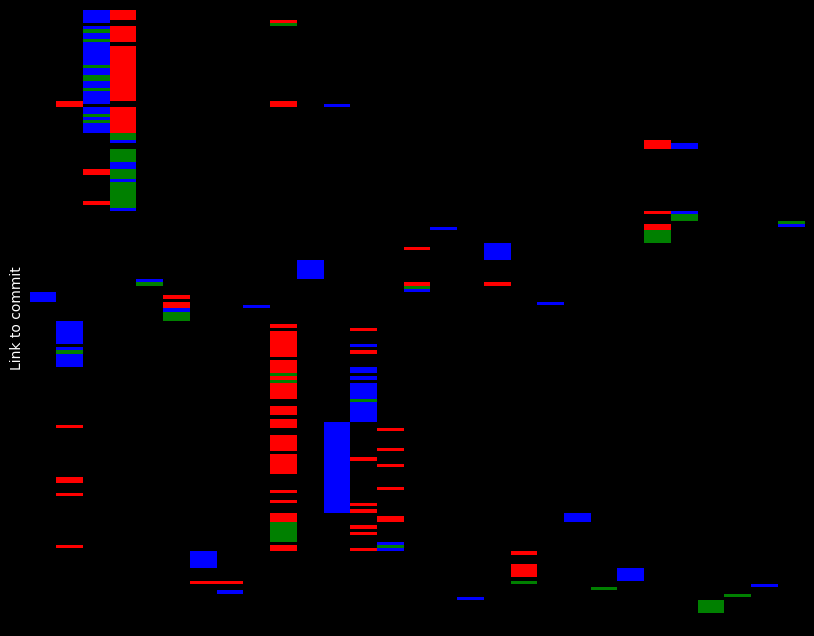

is : Unncessary locks, Unnecessary operation/traversal/function call, Memory/Data locality, Micro-architectural inefficiency, Under-parallelization, Unnecessary synchronization, memory leak, unnecessary data copy, Lock management overhead, Inefficient data-structure library, Inefficeint thread mapping / inefficient block size / Load imbalance, Expensive operation, Redundant operation, Usage of improper data type, Over-Parallelization, Instruction level parallelism, over parallelization, small parallel region, Redundant memory allocation, Unncessary strong memory consistency, Frequent  function call, Insufficient memory, repreated memory allocation, Task parallelism, Vector/SIMD parallelism, boundary condition check, sequential I/O operation, Slower memory allocation library call, GPU parallelism, 


In [62]:
from matplotlib.colors import ListedColormap

# Get the common indexes
common_index = RQ1_sub_CAT_one_hot_df.index.intersection(pred_sub_cat_df.index)

# Subset the DataFrames using the common index
RQ1_sub_CAT_one_hot_df_common = RQ1_sub_CAT_one_hot_df.loc[common_index]
pred_sub_cat_df_common = pred_sub_cat_df.loc[common_index]

# Make sure both DataFrames are aligned and have the same columns
RQ1_sub_CAT_one_hot_df_common = RQ1_sub_CAT_one_hot_df_common[pred_sub_cat_df_common.columns]

# Define the rules for the new DataFrame
conditions = [
    (RQ1_sub_CAT_one_hot_df_common == 1) & (pred_sub_cat_df_common == 1),  # Both are 1
    (RQ1_sub_CAT_one_hot_df_common == 0) & (pred_sub_cat_df_common == 1),  # Pred is 1, RQ1_sub_CAT_one_hot_df is 0
    (RQ1_sub_CAT_one_hot_df_common == 1) & (pred_sub_cat_df_common == 0),  # Pred is 0, RQ1_sub_CAT_one_hot_df is 1
    (RQ1_sub_CAT_one_hot_df_common == 0) & (pred_sub_cat_df_common == 0)  # Both are 0
]

# Define the corresponding values (you can use any unique values)
values = [3, 2, 1, 0]

# Create the new DataFrame using np.select to map conditions to values
df_new = pd.DataFrame(np.select(conditions, values, default=np.nan), 
                      index=RQ1_sub_CAT_one_hot_df_common.index, columns=RQ1_sub_CAT_one_hot_df_common.columns)

# Define the color map
cmap = ListedColormap(['black', 'blue', 'red', 'green'])

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_new, cmap=cmap, cbar=False)

# Remove y-axis labels
plt.xticks([])
plt.yticks([])
plt.show()

tmp_str = ""
for i in df_new.columns:
    tmp_str += i + ", "
print("is :" ,tmp_str)


In [63]:
condition_counts = df_new.stack().value_counts()

#print(condition_counts)
#3 for both are 1,
#2 for Pred is 1, RQ1_CAT_one_hot_df is 0,
#1 for Pred is 0, RQ1_CAT_one_hot_df is 1,
#0 for both are 0.
print(f"both predict 0 {condition_counts[0]}")
print(f"both predicts 1 {condition_counts[3]}")
print(f"model predicts 0 ground truth is 1 {condition_counts[1]}")
print(f"model predicts 1 ground truth is 0 {condition_counts[2]}")
TP = condition_counts[3]
TN = condition_counts[0]
FP = condition_counts[2]
FN = condition_counts[1]

accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
false_negative_rate = FN / (FN + TP) if (FN + TP) > 0 else 0

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")
print(f"False Negative Rate: {false_negative_rate}")


both predict 0 5202
both predicts 1 56
model predicts 0 ground truth is 1 130
model predicts 1 ground truth is 0 122
Accuracy: 0.9542649727767695
Precision: 0.3146067415730337
Recall: 0.3010752688172043
F1 Score: 0.3076923076923077
False Negative Rate: 0.6989247311827957


The performance evaluation metrics of the model deliver unique insights:

Accuracy (95.43%): The model's accuracy, which represents the proportion of correct predictions (both true positives and true negatives) over all predictions, is 95.43%. This suggests that the model can predict correctly in 95.43% of the cases. However, this metric can often be misleading if the classes in the dataset are unbalanced. Even though the accuracy seems impressive, caution is advised in such scenarios.

Precision (31.46%): Precision, defined as the proportion of true positives to all positive predictions (true positives and false positives), stands at 31.46%. This relatively low score implies that the model only correctly predicts a positive class 31.46% of the time. The model thus demonstrates a significant rate of false positives, inaccurately identifying negative instances as positive.

Recall (30.11%): The model's recall, also known as sensitivity, measures the proportion of true positives to all actual positive instances (true positives and false negatives). A recall rate of 30.11% signifies that the model successfully identifies only 30.11% of all positive instances. This low recall score reveals the model's inability to detect a substantial number of positive instances.

F1 Score (30.77%): The F1 Score is the harmonic mean of precision and recall, providing a balanced measure of these two metrics. An F1 Score closer to 1 is ideal, as it signifies well-balanced precision and recall. The current model's F1 score, being quite low, suggests a lack of harmony between the model's precision and recall.

False Negative Rate (69.89%): The False Negative Rate (FNR) represents the proportion of actual positive instances incorrectly classified as negative by the model. A high FNR is typically undesirable because it indicates frequent misclassifications of positive instances. In this case, the high FNR suggests that the model often fails to accurately identify positive instances.

In summary, despite a high accuracy, the model's performance seems inadequate, particularly in its correct identification of positive instances. Evidenced by the high number of false negatives (missed positives) and a considerable number of false positives (low precision), the model requires improvement. Potential improvement strategies could include trying different algorithms, tuning the model's hyperparameters, implementing feature engineering techniques, rebalancing the dataset if it is imbalanced, or acquiring more relevant data. Importantly, the chosen metrics for performance evaluation should align with the specific requirements and context of the task. Depending on the problem, a higher False Negative Rate might sometimes be more acceptable than a higher False Positive Rate, and vice versa.